In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import sys
sys.path.append("/global/homes/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/LightningModules/TrackML_ACAT")
import cuml
import torch
event = torch.load("/global/cfs/cdirs/m3443/data/trackml-codalab/gnn_processed/1GeV_pt_cut_quickstart_example/test/1011")
from tracking_utils import eval_metrics, visualizing_embedding_space
from torch_geometric.data import Data
import yaml
import os
sys.path.append('../..')
from LightningModules.TrackML_ACAT.GNNEmbedding.Models.HGNN_GMM import Embedding_HierarchicalGNN_GMM as HierarchicalGNN
from LightningModules.TrackML_ACAT.training_utils import model_selector
from pytorch_lightning import Trainer
import matplotlib.pyplot as plt

event = Data.from_dict(event.__dict__)
event.scores = (event.scores[:len(event.scores)//2] + event.scores[len(event.scores)//2:])/2
bipartite_graph = torch.stack([torch.arange(len(event.pid), device = "cuda"), event.pid], dim = 0).long()

In [3]:
eval_metrics(bipartite_graph, event, pt_cut =1., primary = False)

{'track_eff': 1.0, 'track_pur': 1.0, 'hit_eff': 1.0, 'hit_pur': 1.0}

In [4]:
import cudf
import cugraph
import cupy as cp
import numpy as np

In [5]:
def track_candidate_generation(event, scores, score_cut, truth = False):
    G = cugraph.Graph()
    if truth:
        df = cudf.DataFrame({"src": cp.asarray(event.edge_index[0][event.pid[event.edge_index[0]]==event.pid[event.edge_index[1]]]),
                             "dst": cp.asarray(event.edge_index[1][event.pid[event.edge_index[0]]==event.pid[event.edge_index[1]]]),
                             "weights": cp.asarray(scores[event.pid[event.edge_index[0]]==event.pid[event.edge_index[1]]])})
    else:
        df = cudf.DataFrame({"src": cp.asarray(event.edge_index[0]),
                             "dst": cp.asarray(event.edge_index[1]),
                             "weights": cp.asarray(scores)})
    if truth:
        pass
    else:
        df = df[df["weights"] >= score_cut]
    G.from_cudf_edgelist(df,source = "src", destination = "dst", edge_attr = "weights")
    connected_components = cugraph.components.connected_components(G)
    bipartite_graph = torch.stack([torch.as_tensor(connected_components["vertex"]), torch.as_tensor(connected_components["labels"])], dim = 0)
    return eval_metrics(bipartite_graph, event, pt_cut =1., primary = False, nhits_cut = 5, majority_cut = 0.5)

In [6]:
track_candidate_generation(event, event.scores, 0.9941)

/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/cudf/core/indexed_frame.py:2271: FutureWarning: append is deprecated and will be removed in a future version. Use concat instead.
  warnings.warn(


{'track_eff': 0.6817820206841687,
 'track_pur': 0.6022487702037947,
 'hit_eff': 0.8675815105494562,
 'hit_pur': 0.9973864067614067}

In [7]:
def get_statistics(truth = False, score_cut = 0.8):
    with open("GNN_embedding_default.yaml") as f:
        hparams = yaml.load(f, Loader=yaml.FullLoader)
        
    if hparams["use_toy"]:
        hparams["regime"] = []
        hparams["spatial_channels"] = 2
    if hparams["hidden"] == "ratio":
        hparams["hidden"] = hparams["hidden_ratio"]*hparams["latent"]

    if hparams["model"] == "HGNN" or "LHGNN":
        model = HierarchicalGNN(hparams)
    if hparams["model"] == "IGNN":
        model = InteractionGNN(hparams)

    model.setup("test")
    results = None
    for event in model.test_dataloader():
        if results is None:
            results = track_candidate_generation(event, event.scores, score_cut, truth)
        else:
            new_results = track_candidate_generation(event, event.scores, score_cut, truth)
            for name in results.keys():
                results[name] += new_results[name]
    for name in results.keys():
        results[name] = results[name]/len(model.test_dataloader())
    return results

In [8]:
results = get_statistics(score_cut = 0.82, truth = True)
print(*[results[i] for i in results], sep = '\n')

FileNotFoundError: [Errno 2] No such file or directory: 'GNN_embedding_default.yaml'

## Visualization

In [12]:
def load_from_pretrained(model, path = None, ckpt = None):
    
    if ckpt is None:
        ckpt = torch.load(path)
    else:
        pass
    state_dict = ckpt["state_dict"]
    model.load_state_dict(state_dict, strict=False)
    del state_dict
    
    return model

In [24]:
with open("GNN_embedding_default.yaml") as f:
    hparams = yaml.load(f, Loader=yaml.FullLoader)
if hparams["use_toy"]:
    hparams["regime"] = []
    hparams["spatial_channels"] = 2
    
if hparams["hidden"] == "ratio":
    hparams["hidden"] = hparams["hidden_ratio"]*hparams["latent"]

if hparams["model"] == "HGNN" or "LHGNN":
    model = HierarchicalGNN(hparams)
if hparams["model"] == "IGNN":
    model = InteractionGNN(hparams)

model_path = "/global/cfs/cdirs/m3443/usr/ryanliu/TrackML/TrackML_embedding/abiz20ah/checkpoints/last.ckpt"
model = load_from_pretrained(model, model_path)
model.setup("test")
trainer = Trainer(gpus=1)

/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [25]:
model = model.cuda()
with torch.no_grad():
    embeddings, *misc = model(event.x, event.edge_index)

/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Label prop iterations: 15
Label prop iterations: 7
Label prop iterations: 6
Label prop iterations: 6
Label prop iterations: 4
Label prop iterations: 3
Iterations: 6
74741,194,293,16,323,1375
Label prop iterations: 5
Label prop iterations: 5
Label prop iterations: 3
Label prop iterations: 2
Iterations: 4
878,119,192,10,197,558


/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/pytorch_lightning/core/lightning.py:372: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


<Axes3DSubplot:>

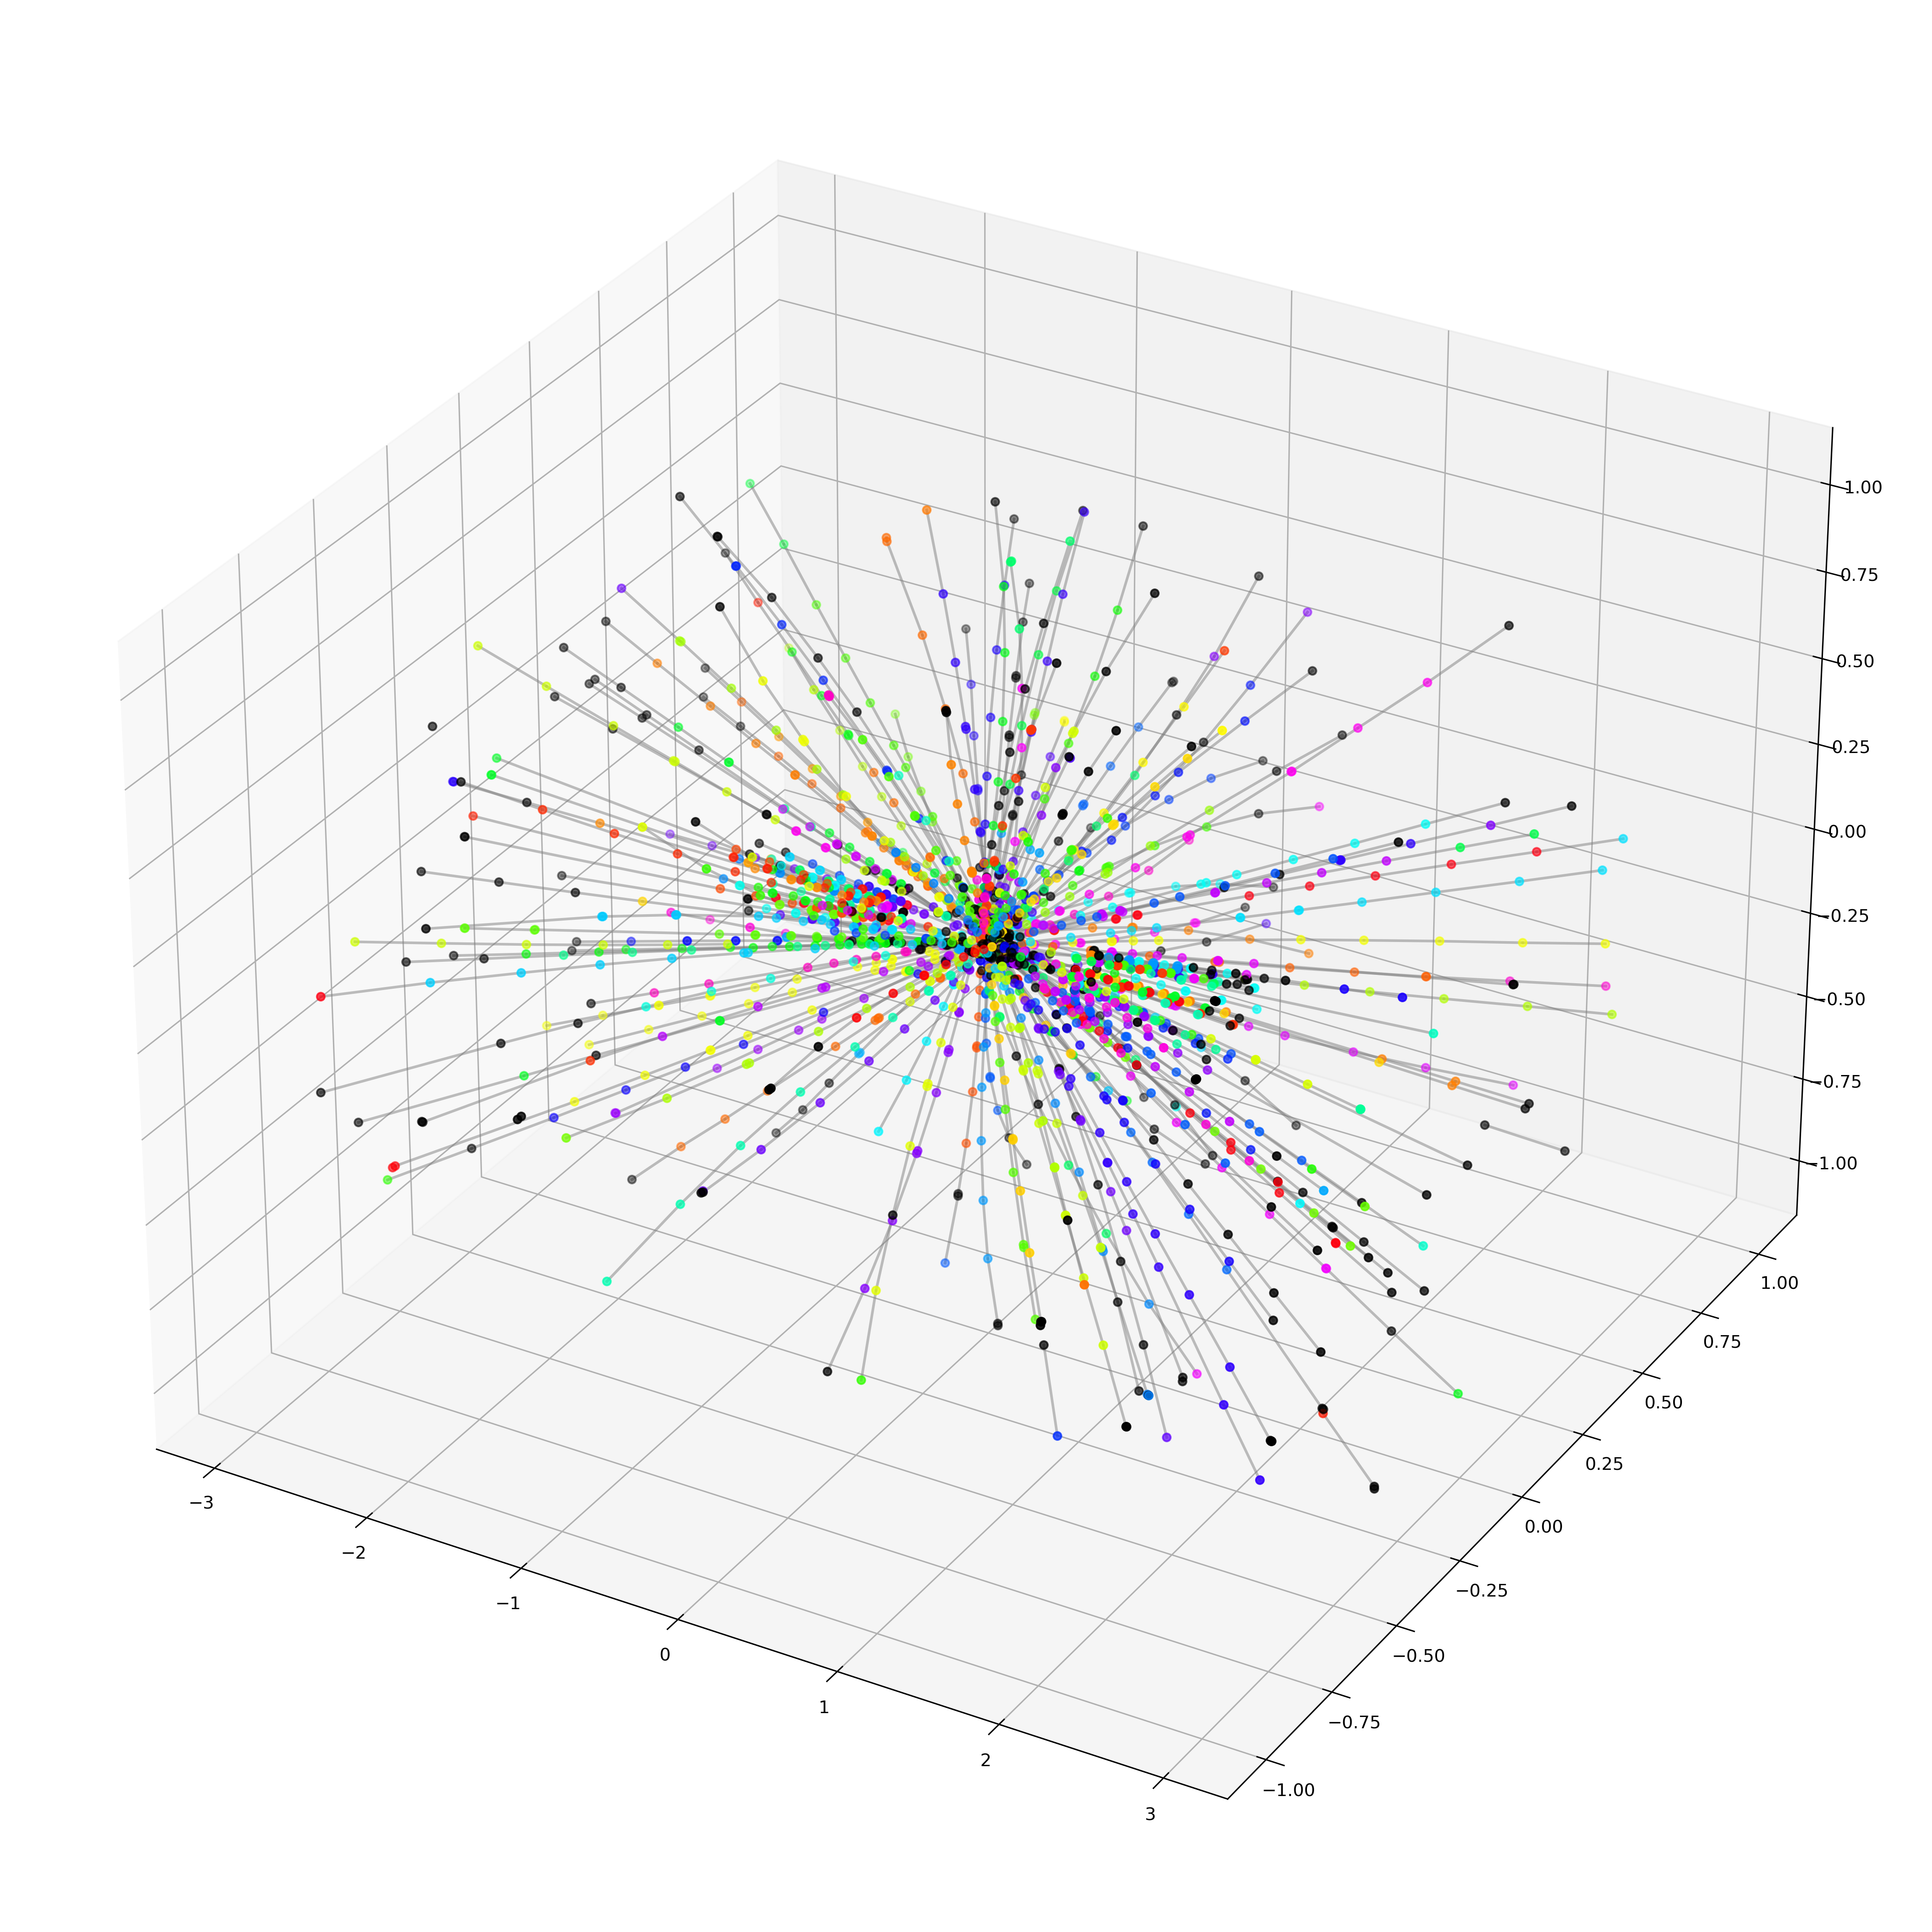

In [26]:
visualizing_embedding_space(event, misc[0], misc[1], num_tracks_visualized = 200, regime = "random coloring", alpha = 0.5, color = "grey", ms = 1)
# plt.savefig('misc/200tracks_intermediate_random_coloring.png')

In [27]:
from cuml.cluster import HDBSCAN
HDBSCANmodel = HDBSCAN(min_cluster_size = hparams["inference_min_cluster_size"], metric='euclidean', cluster_selection_method = "eom", verbose = 0)
clusters = HDBSCANmodel.fit_predict(embeddings)
clusters = torch.as_tensor(clusters).long()

Label prop iterations: 11
Label prop iterations: 4
Label prop iterations: 2
Iterations: 3
722,101,169,9,161,594
Label prop iterations: 7
Label prop iterations: 7
Label prop iterations: 9
Label prop iterations: 3
Iterations: 4
534,121,190,10,209,855
Label prop iterations: 3
Label prop iterations: 2
Iterations: 2
518,73,116,6,103,214


<Axes3DSubplot:>

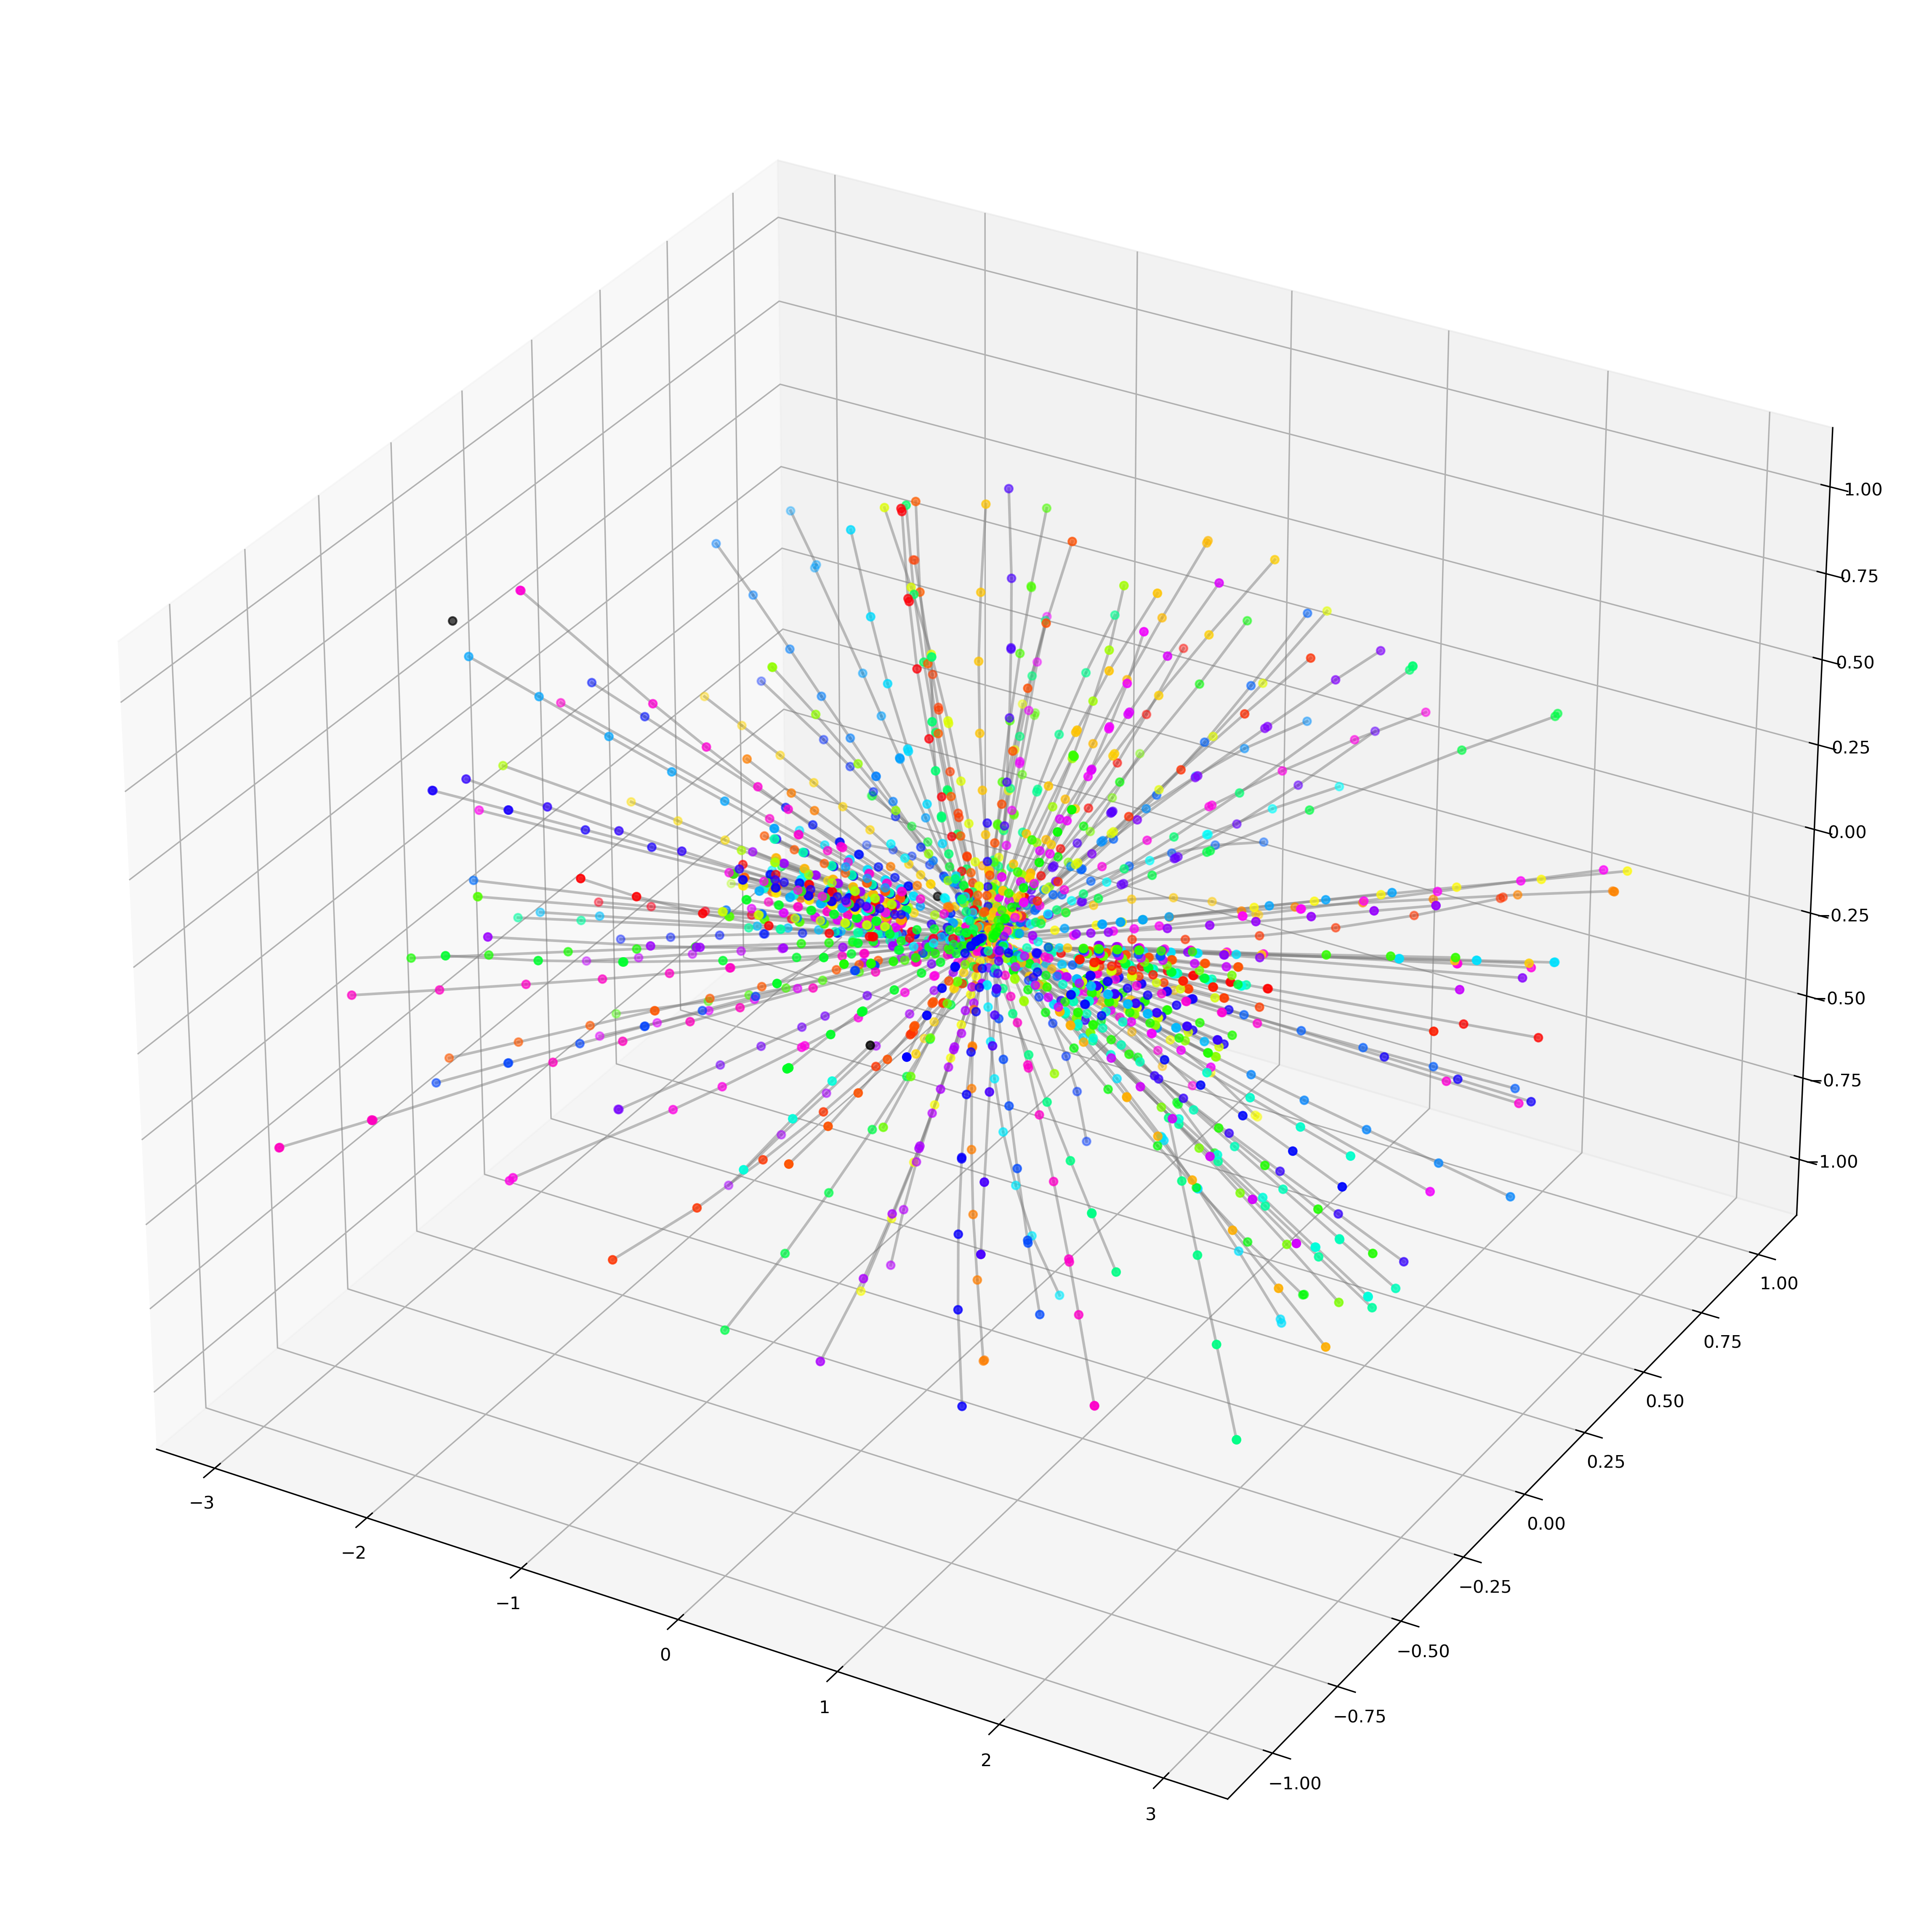

In [28]:
visualizing_embedding_space(event, embeddings, clusters, num_tracks_visualized = 200, regime = "random coloring", alpha = 0.5, color = "grey", ms = 1)
# plt.savefig('misc/200tracks_final_random_coloring.png')

## Timing

In [8]:
import time
def get_timing():
    inference_config = {
    "majority_cut": float(input()),
    "score_cut": 0.5
    }
    model_path = "/global/cfs/cdirs/m3443/usr/ryanliu/TrackML/TrackML_1GeV/{}/checkpoints/".format(input())
    model_paths = os.listdir(model_path)
    model_paths.remove("last.ckpt")
    ckpt_name = model_paths[0]
    for i in model_paths:
        if int(i.strip("epoch=").split("-")[0]) > int(ckpt_name.strip("epoch=").split("-")[0]):
            ckpt_name = i
    model_path = os.path.join(model_path, ckpt_name)

    ckpt = torch.load(model_path)
    sweep_configs = inference_config

    model = model_selector(ckpt["hyper_parameters"]["model"], sweep_configs)

    model = load_from_pretrained(model, ckpt = ckpt)
    model.setup("test")
    model = model.cuda()
    tot_time = 0
    for event in model.test_dataloader():
        event = event.cuda()
        start = time.time()
        _ = model.shared_evaluation(event, 0, log=False)
        end = time.time()
        tot_time += end - start
        
    return tot_time/len(model.test_dataloader())

In [13]:
with torch.no_grad():
    print(get_timing())

 0.5
 1rij2zgw


/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/pytorch_lightning/core/lightning.py:372: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/cudf/core/indexed_frame.py:2271: FutureWarning: append is deprecated and will be removed in a future version. Use concat instead.
  warnings

Label prop iterations: 12
Label prop iterations: 5
Label prop iterations: 3
Label prop iterations: 2
Iterations: 4
12144,137,187,15,213,774
Label prop iterations: 7
Label prop iterations: 6
Label prop iterations: 5
Label prop iterations: 3
Iterations: 4
536,120,175,10,209,689
Label prop iterations: 2
Label prop iterations: 2
Iterations: 2
527,68,104,5,95,171


/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/pytorch_lightning/core/lightning.py:372: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/cudf/core/indexed_frame.py:2271: FutureWarning: append is deprecated and will be removed in a future version. Use concat instead.
  warnings.warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Label prop iterations: 12
Label prop iterations: 5
Label prop iterations: 3
Label prop iterations: 2
Iterations: 4
611,108,147,11,184,668
Label prop iterations: 7
Label prop iterations: 9
Label prop iterations: 4
Label prop iterations: 4
Iterations: 4
444,101,140,8,171,690
Label prop iterations: 2
Iterations: 1
428,41,56,4,44,84


/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/pytorch_lightning/core/lightning.py:372: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/cudf/core/indexed_frame.py:2271: FutureWarning: append is deprecated and will be removed in a future version. Use concat instead.
  warnings.warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Label prop iterations: 11
Label prop iterations: 5
Label prop iterations: 4
Label prop iterations: 2
Iterations: 4
602,107,138,11,179,665
Label prop iterations: 8
Label prop iterations: 8
Label prop iterations: 4
Label prop iterations: 4
Iterations: 4
450,102,143,7,176,699
Label prop iterations: 2
Label prop iterations: 2
Iterations: 2
434,61,75,6,87,165


/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/pytorch_lightning/core/lightning.py:372: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/cudf/core/indexed_frame.py:2271: FutureWarning: append is deprecated and will be removed in a future version. Use concat instead.
  warnings.warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Label prop iterations: 12
Label prop iterations: 5
Label prop iterations: 3
Label prop iterations: 2
Iterations: 4
571,102,129,12,173,654
Label prop iterations: 7
Label prop iterations: 5
Label prop iterations: 4
Label prop iterations: 4
Iterations: 4
409,97,137,8,165,586
Label prop iterations: 2
Iterations: 1
398,40,47,4,41,83


/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/pytorch_lightning/core/lightning.py:372: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/cudf/core/indexed_frame.py:2271: FutureWarning: append is deprecated and will be removed in a future version. Use concat instead.
  warnings.warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Label prop iterations: 12
Label prop iterations: 4
Label prop iterations: 4
Iterations: 3
535,80,96,9,128,560
Label prop iterations: 7
Label prop iterations: 5
Label prop iterations: 5
Label prop iterations: 4
Label prop iterations: 2
Iterations: 5
389,110,149,10,199,674
Label prop iterations: 2
Label prop iterations: 2
Iterations: 2
366,55,64,6,77,151


/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/pytorch_lightning/core/lightning.py:372: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/cudf/core/indexed_frame.py:2271: FutureWarning: append is deprecated and will be removed in a future version. Use concat instead.
  warnings.warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Label prop iterations: 11
Label prop iterations: 6
Label prop iterations: 3
Iterations: 3
722,80,104,10,133,565
Label prop iterations: 6
Label prop iterations: 6
Label prop iterations: 7
Label prop iterations: 2
Iterations: 4
383,92,128,10,159,598
Label prop iterations: 2
Iterations: 1
365,37,47,4,41,79


/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/pytorch_lightning/core/lightning.py:372: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/cudf/core/indexed_frame.py:2271: FutureWarning: append is deprecated and will be removed in a future version. Use concat instead.
  warnings.warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Label prop iterations: 14
Label prop iterations: 5
Label prop iterations: 2
Label prop iterations: 2
Iterations: 4
528,98,127,16,160,655
Label prop iterations: 9
Label prop iterations: 7
Label prop iterations: 8
Label prop iterations: 3
Iterations: 4
389,94,123,6,150,729
Label prop iterations: 2
Label prop iterations: 2
Iterations: 2
374,61,73,6,89,171


/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/pytorch_lightning/core/lightning.py:372: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/cudf/core/indexed_frame.py:2271: FutureWarning: append is deprecated and will be removed in a future version. Use concat instead.
  warnings.warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Label prop iterations: 12
Label prop iterations: 5
Label prop iterations: 4
Iterations: 3
903,82,112,10,136,584
Label prop iterations: 6
Label prop iterations: 7
Label prop iterations: 5
Label prop iterations: 4
Iterations: 4
386,99,134,10,174,659
Label prop iterations: 2
Iterations: 1
392,40,51,4,46,84


/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/pytorch_lightning/core/lightning.py:372: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/cudf/core/indexed_frame.py:2271: FutureWarning: append is deprecated and will be removed in a future version. Use concat instead.
  warnings.warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Label prop iterations: 13
Label prop iterations: 5
Label prop iterations: 3
Iterations: 3
918,85,116,13,135,589
Label prop iterations: 8
Label prop iterations: 6
Label prop iterations: 5
Label prop iterations: 3
Label prop iterations: 2
Iterations: 5
400,117,160,10,198,699
Label prop iterations: 3
Label prop iterations: 2
Iterations: 2
375,56,79,5,82,179


/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/pytorch_lightning/core/lightning.py:372: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/cudf/core/indexed_frame.py:2271: FutureWarning: append is deprecated and will be removed in a future version. Use concat instead.
  warnings.warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Label prop iterations: 11
Label prop iterations: 4
Label prop iterations: 3
Iterations: 3
536,81,97,9,128,528
Label prop iterations: 7
Label prop iterations: 6
Label prop iterations: 6
Label prop iterations: 4
Iterations: 4
391,93,119,9,159,643
Label prop iterations: 2
Iterations: 1
376,38,44,4,39,79


/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/pytorch_lightning/core/lightning.py:372: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/cudf/core/indexed_frame.py:2271: FutureWarning: append is deprecated and will be removed in a future version. Use concat instead.
  warnings.warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Label prop iterations: 16
Label prop iterations: 5
Label prop iterations: 4
Label prop iterations: 3
Iterations: 4
744,100,136,13,182,789
Label prop iterations: 6
Label prop iterations: 8
Label prop iterations: 8
Label prop iterations: 2
Label prop iterations: 2
Iterations: 5
400,111,150,11,202,746
Label prop iterations: 2
Label prop iterations: 2
Iterations: 2
379,57,76,6,81,154


/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/pytorch_lightning/core/lightning.py:372: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/cudf/core/indexed_frame.py:2271: FutureWarning: append is deprecated and will be removed in a future version. Use concat instead.
  warnings.warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Label prop iterations: 15
Label prop iterations: 4
Label prop iterations: 4
Iterations: 3
551,82,118,8,134,635
Label prop iterations: 9
Label prop iterations: 6
Label prop iterations: 5
Label prop iterations: 3
Label prop iterations: 2
Iterations: 5
398,113,163,11,202,730
Label prop iterations: 3
Label prop iterations: 2
Iterations: 2
377,58,82,6,83,179


/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/pytorch_lightning/core/lightning.py:372: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/cudf/core/indexed_frame.py:2271: FutureWarning: append is deprecated and will be removed in a future version. Use concat instead.
  warnings.warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Label prop iterations: 12
Label prop iterations: 5
Label prop iterations: 2
Label prop iterations: 2
Iterations: 4
774,105,141,12,173,630
Label prop iterations: 7
Label prop iterations: 7
Label prop iterations: 4
Label prop iterations: 3
Label prop iterations: 2
Iterations: 5
423,117,156,10,204,692
Label prop iterations: 3
Iterations: 1
401,39,53,4,43,104


/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/pytorch_lightning/core/lightning.py:372: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/cudf/core/indexed_frame.py:2271: FutureWarning: append is deprecated and will be removed in a future version. Use concat instead.
  warnings.warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Label prop iterations: 11
Label prop iterations: 5
Label prop iterations: 3
Iterations: 3
541,81,119,9,131,544
Label prop iterations: 6
Label prop iterations: 5
Label prop iterations: 5
Label prop iterations: 4
Iterations: 4
395,94,132,8,159,573
Label prop iterations: 3
Label prop iterations: 2
Iterations: 2
372,57,80,5,81,177


/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/pytorch_lightning/core/lightning.py:372: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/cudf/core/indexed_frame.py:2271: FutureWarning: append is deprecated and will be removed in a future version. Use concat instead.
  warnings.warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Label prop iterations: 13
Label prop iterations: 4
Label prop iterations: 4
Label prop iterations: 2
Iterations: 4
919,100,141,12,172,675
Label prop iterations: 6
Label prop iterations: 7
Label prop iterations: 5
Label prop iterations: 3
Label prop iterations: 2
Iterations: 5
396,112,164,10,206,676
Label prop iterations: 2
Iterations: 1
373,39,51,4,41,81


/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/pytorch_lightning/core/lightning.py:372: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/cudf/core/indexed_frame.py:2271: FutureWarning: append is deprecated and will be removed in a future version. Use concat instead.
  warnings.warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Label prop iterations: 12
Label prop iterations: 5
Label prop iterations: 4
Label prop iterations: 3
Iterations: 4
542,101,144,11,172,686
Label prop iterations: 6
Label prop iterations: 5
Label prop iterations: 5
Label prop iterations: 4
Iterations: 4
404,105,137,8,161,578
Label prop iterations: 2
Label prop iterations: 2
Iterations: 2
379,57,80,6,79,153


/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/pytorch_lightning/core/lightning.py:372: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/cudf/core/indexed_frame.py:2271: FutureWarning: append is deprecated and will be removed in a future version. Use concat instead.
  warnings.warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Label prop iterations: 13
Label prop iterations: 5
Label prop iterations: 4
Iterations: 3
894,81,110,9,137,606
Label prop iterations: 7
Label prop iterations: 7
Label prop iterations: 4
Label prop iterations: 3
Iterations: 4
383,97,127,10,159,596
Label prop iterations: 3
Label prop iterations: 2
Iterations: 2
361,55,74,6,81,175


/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/pytorch_lightning/core/lightning.py:372: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/cudf/core/indexed_frame.py:2271: FutureWarning: append is deprecated and will be removed in a future version. Use concat instead.
  warnings.warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Label prop iterations: 14
Label prop iterations: 6
Label prop iterations: 4
Label prop iterations: 2
Iterations: 4
720,97,123,11,163,721
Label prop iterations: 6
Label prop iterations: 6
Label prop iterations: 5
Label prop iterations: 3
Iterations: 4
377,91,116,10,158,577
Label prop iterations: 3
Iterations: 1
363,37,47,4,39,101


/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/pytorch_lightning/core/lightning.py:372: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/cudf/core/indexed_frame.py:2271: FutureWarning: append is deprecated and will be removed in a future version. Use concat instead.
  warnings.warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Label prop iterations: 11
Label prop iterations: 5
Label prop iterations: 3
Label prop iterations: 2
Iterations: 4
899,100,134,12,169,615
Label prop iterations: 6
Label prop iterations: 6
Label prop iterations: 6
Label prop iterations: 3
Label prop iterations: 2
Iterations: 5
374,113,147,11,193,666
Label prop iterations: 3
Label prop iterations: 3
Iterations: 2
362,56,75,6,79,197


/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/pytorch_lightning/core/lightning.py:372: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/cudf/core/indexed_frame.py:2271: FutureWarning: append is deprecated and will be removed in a future version. Use concat instead.
  warnings.warn(
/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Label prop iterations: 11
Label prop iterations: 5
Label prop iterations: 3
Label prop iterations: 2
Iterations: 4
510,98,138,11,165,610
Label prop iterations: 7
Label prop iterations: 5
Label prop iterations: 5
Label prop iterations: 5
Label prop iterations: 2
Iterations: 5
374,109,151,11,194,681
Label prop iterations: 3
Label prop iterations: 2
Iterations: 2
350,55,77,6,80,173
0.5280384540557861


/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Stats

In [10]:
import matplotlib.pyplot as plt

In [11]:
def visualizing_stats(scores, y, n_steps = 20, tot = True, log = False):
    x_ticks = np.linspace(scores.min(), scores.max(), n_steps+1)
    true_stats = np.zeros(n_steps+1).astype(np.int32)
    true_stats[np.unique(np.digitize(scores[y == 1].numpy(), x_ticks))-1] = np.unique(np.digitize(scores[y == 1].numpy(), x_ticks), return_counts = True)[1]
    fake_stats = np.zeros(n_steps+1).astype(np.int32)
    fake_stats[np.unique(np.digitize(scores[y == 0].numpy(), x_ticks))-1] = np.unique(np.digitize(scores[y == 0].numpy(), x_ticks), return_counts = True)[1]
    if tot:
        tot_stats = np.zeros(n_steps+1).astype(np.int32)
        tot_stats[np.unique(np.digitize(scores.numpy(), x_ticks))-1] = np.unique(np.digitize(scores.numpy(), x_ticks), return_counts = True)[1]
    plt.figure(figsize = (10, 10))
    mask = np.arange(len(x_ticks))
    mask[mask > 0] = mask[mask > 0] - 1
    plt.plot(x_ticks, true_stats[mask], color = "orange", ds='steps')
    plt.plot(x_ticks, fake_stats[mask], color = "blue", ds='steps')
    if tot:
        plt.plot(x_ticks, tot_stats[mask], color = "red", ds='steps')
    if log: plt.yscale('log')
    plt.show()

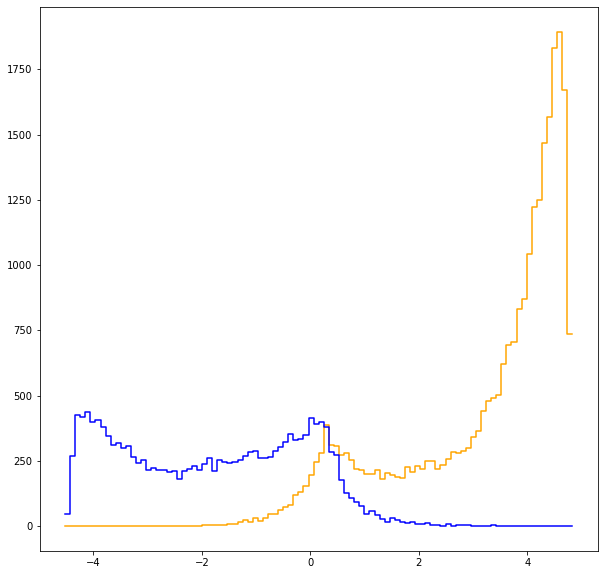

In [15]:
visualizing_stats(torch.atanh(2*event.scores-1).cpu(), event.y_pid.cpu(), n_steps = 100, log = False, tot = False)

In [16]:
likelihood = torch.einsum('ij,ij->i', misc[0][event.edge_index[0]], misc[0][event.edge_index[1]])
# likelihood = torch.einsum('ij,ij->i', embeddings[event.edge_index[0]], embeddings[event.edge_index[1]])

NameError: name 'misc' is not defined

In [17]:
visualizing_stats(torch.atanh(torch.clamp(likelihood, min=-1+1e-7, max=1-1e-7)).cpu(), event.y_pid.cpu(), n_steps = 100, tot = False, log = False)

NameError: name 'likelihood' is not defined

In [52]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.optimize import fsolve

In [35]:
model = GaussianMixture(n_components = 2)

In [36]:
%time
prediction = model.fit_predict(torch.atanh(2*event.scores-1).unsqueeze(1).cpu().numpy())
print(model.means_, model.covariances_)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.39 µs
[[ 4.18435427]
 [-0.45451665]] [[[0.18784492]]

 [[5.18001922]]]


In [37]:
cut = event.scores[prediction == model.means_.argmax()].min().item()
print(cut)

0.9983810186386108


In [38]:
track_candidate_generation(event, torch.atanh(2*event.scores-1), cut)

/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/cudf/core/indexed_frame.py:2271: FutureWarning: append is deprecated and will be removed in a future version. Use concat instead.
  warnings.warn(


{'track_eff': 0.8273667462211615,
 'track_pur': 0.7008086253369272,
 'hit_eff': 0.8943901779401303,
 'hit_pur': 0.9845308310096931}

In [55]:
def determine_cut(model, cut0):
    func = lambda x: model.predict_proba(x.reshape((-1, 1)))[:, 0] - model.predict_proba(x.reshape((-1, 1)))[:, 1]
    cut = fsolve(func, cut0)
    return cut

In [60]:
def auto_cut_track_candidate_selection(event, scores):
    model = GaussianMixture(n_components = 2)
    prediction = model.fit_predict(scores.unsqueeze(1).cpu().numpy())
    cut1 = scores[prediction == model.means_.argmin()].max().item()
    cut2 = scores[prediction == model.means_.argmax()].min().item()
    cut = cut2 if cut2 < model.means_.max() and cut2 > model.means_.min() else cut1
    cut = determine_cut(model, cut).item()
    return track_candidate_generation(event, scores, cut)

In [61]:
auto_cut_track_candidate_selection(event, torch.atanh(torch.clamp(likelihood, min=-1+1e-6, max=1-1e-6)))

/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/cudf/core/indexed_frame.py:2271: FutureWarning: append is deprecated and will be removed in a future version. Use concat instead.
  warnings.warn(


{'track_eff': 0.18933969769291964,
 'track_pur': 0.1853582554517134,
 'hit_eff': 0.6325030838470038,
 'hit_pur': 0.9975490196078431}

In [41]:
auto_cut_track_candidate_selection(event, likelihood)

/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/cudf/core/indexed_frame.py:2271: FutureWarning: append is deprecated and will be removed in a future version. Use concat instead.
  warnings.warn(


{'track_eff': 0.3643595863166269,
 'track_pur': 0.7882960413080895,
 'hit_eff': 0.9760838324702954,
 'hit_pur': 0.929553424131482}

In [42]:
model = GaussianMixture(n_components = 2)
prediction = model.fit_predict(torch.atanh(torch.clamp(likelihood, min=-1+1e-7, max=1-1e-7)).unsqueeze(1).cpu().numpy())
cut1 = torch.atanh(torch.clamp(likelihood, min=-1+1e-7, max=1-1e-7))[prediction == model.means_.argmin()].max().item()
cut2 = torch.atanh(torch.clamp(likelihood, min=-1+1e-7, max=1-1e-7))[prediction == model.means_.argmax()].min().item()
cut = cut2 if cut2 < model.means_.max() and cut2 > model.means_.min() else cut1 
G = cugraph.Graph()
df = cudf.DataFrame({"src": cp.asarray(event.edge_index[0]),
                     "dst": cp.asarray(event.edge_index[1]),
                     "weights": cp.asarray(torch.atanh(torch.clamp(likelihood, min=-1+1e-7, max=1-1e-7)))})
df = df[df["weights"] >= cut]
G.from_cudf_edgelist(df, source = "src", destination = "dst", edge_attr = "weights")
connected_components = cugraph.components.connected_components(G)
bipartite_graph = torch.stack([torch.as_tensor(connected_components["vertex"]), torch.as_tensor(connected_components["labels"])], dim = 0)

/global/homes/r/ryanliu/.conda/envs/rapids/lib/python3.8/site-packages/cudf/core/indexed_frame.py:2271: FutureWarning: append is deprecated and will be removed in a future version. Use concat instead.
  warnings.warn(


In [43]:
mask = torch.zeros(event.pid.shape[0]).bool()
_, inverse, counts = bipartite_graph[1].unique(return_inverse = True, return_counts = True)
vertex = torch.tensor(connected_components["vertex"]).long()
mask[vertex] = counts[inverse] >= 3
clusters = torch.zeros(event.pid.shape).long()
clusters[torch.as_tensor(connected_components["vertex"])] = torch.as_tensor(connected_components["labels"]).long()

In [44]:
graph = clusters[event.edge_index[:, mask[event.edge_index].all(0)]]

In [45]:
df = cudf.DataFrame({"src": cp.asarray(graph[0]),
                     "dst": cp.asarray(graph[1])})
df = cugraph.symmetrize_df(df, 'src', 'dst', symmetrize=True)
graph = torch.stack([torch.as_tensor(df["src"]), torch.as_tensor(df["dst"])], dim = 0)

In [46]:
graph.shape

torch.Size([2, 954])

In [47]:
from scipy import sparse

In [48]:
original_graph = sparse.coo_matrix((np.ones(event.edge_index.shape[1]), event.edge_index.cpu().numpy()), shape=(event.pid.shape[0], event.pid.shape[0])).tocsc()
original_graph = (original_graph + original_graph.T)/2

In [49]:
n_hop_graph = original_graph
for i in range(10):
    n_hop_graph = (n_hop_graph + n_hop_graph@original_graph) > 0
n_hop_graph = n_hop_graph > 0
# n_hop_graph = sparse.linalg.expm(original_graph) > 0
n_hop_graph = n_hop_graph.tocoo()
n_hop_graph = torch.from_numpy(
        np.vstack([n_hop_graph.row, n_hop_graph.col])
    ).long()

In [50]:
G = cugraph.Graph()
df = cudf.DataFrame({"src": cp.asarray(n_hop_graph[0][event.pid[n_hop_graph[0]]==event.pid[n_hop_graph[1]]]),
                     "dst": cp.asarray(n_hop_graph[1][event.pid[n_hop_graph[0]]==event.pid[n_hop_graph[1]]])})
G.from_cudf_edgelist(df,source = "src", destination = "dst")
connected_components = cugraph.components.connected_components(G)
bipartite_graph = torch.stack([torch.as_tensor(connected_components["vertex"]), torch.as_tensor(connected_components["labels"])], dim = 0)
print(eval_metrics(bipartite_graph, event, pt_cut =1., primary = False, nhits_cut = 5, majority_cut = 0.5))

{'track_eff': 0.9968178202068417, 'track_pur': 0.9728260869565217, 'hit_eff': 0.987334149844126, 'hit_pur': 1.0}


## GMM Model Visualization

In [12]:
sys.path.append('../..')

from LightningModules.TrackML_ACAT.training_utils import model_selector

In [16]:
inference_config = {
    "majority_cut": float(input()),
    "score_cut": 0.5
}
model_path = "/global/cfs/cdirs/m3443/usr/ryanliu/TrackML/TrackML_1GeV/{}/checkpoints/".format(input())
model_paths = os.listdir(model_path)
model_paths.remove("last.ckpt")
ckpt_name = model_paths[0]
for i in model_paths:
    if int(i.strip("epoch=").split("-")[0]) > int(ckpt_name.strip("epoch=").split("-")[0]):
        ckpt_name = i
model_path = os.path.join(model_path, ckpt_name)
    
ckpt = torch.load(model_path)

model = model_selector(ckpt["hyper_parameters"]["model"], {**ckpt["hyper_parameters"], **inference_config})
    
model = load_from_pretrained(model, ckpt = ckpt)
model.setup("test")
model = model.cuda()
with torch.no_grad():
    bipartite_graph, bipartite_scores, intermediate_embeddings = model(event.x, event.edge_index)

 0.5
 168rr48x


Label prop iterations: 13
Label prop iterations: 5
Label prop iterations: 5
Label prop iterations: 4
Iterations: 4
489,107,128,12,178,826
Label prop iterations: 7
Label prop iterations: 6
Label prop iterations: 5
Label prop iterations: 5
Label prop iterations: 2
Iterations: 5
352,115,139,12,206,741
Label prop iterations: 4
Label prop iterations: 3
Iterations: 2
354,62,70,6,85,234


In [17]:
likelihood = torch.einsum('ij,ij->i', intermediate_embeddings[event.edge_index[0]], intermediate_embeddings[event.edge_index[1]])

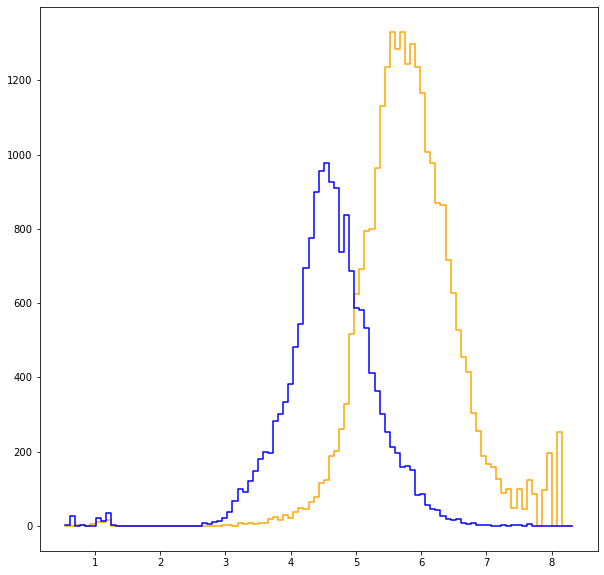

In [18]:
visualizing_stats(torch.atanh(torch.clamp(likelihood, min=-1+1e-7, max=1-1e-7)).cpu(), event.y_pid.cpu(), n_steps = 100, tot = False, log = False)

In [ ]:
visualizing_stats(torch.atanh(torch.clamp(likelihood, min=-1+1e-7, max=1-1e-7)).cpu(), event.y_pid.cpu(), n_steps = 100, tot = False, log = False)